In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import to_categorical
import skimage
from skimage.transform import resize
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
x_train = np.load('/content/drive/My Drive/dataset/64x64-web/xtrain.npy')
y_train = np.load('/content/drive/My Drive/dataset/64x64-web/ytrain.npy')
x_test = np.load('/content/drive/My Drive/dataset/64x64-web/xtest.npy')
y_test = np.load('/content/drive/My Drive/dataset/64x64-web/ytest.npy')
x_val = np.load('/content/drive/My Drive/dataset/64x64-web/xval.npy')
y_val = np.load('/content/drive/My Drive/dataset/64x64-web/yval.npy')

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(5107, 64, 64, 3)
(5107, 2)
(2270, 64, 64, 3)
(2270, 2)
(1703, 64, 64, 3)
(1703, 2)


In [ ]:
from numpy import where
y_train[where(y_train == 0)] = -1
y_test[where(y_test == 0)] = -1
y_val[where(y_val == 0)] = -1

In [ ]:
from collections import Counter
c = Counter(map(tuple, y_train))
print(c)
c = Counter(map(tuple, y_test))
print(c)
c = Counter(map(tuple, y_val))
print(c)

Counter({(-1.0, 1.0): 2565, (1.0, -1.0): 2542})
Counter({(1.0, -1.0): 1149, (-1.0, 1.0): 1121})
Counter({(1.0, -1.0): 890, (-1.0, 1.0): 813})


In [ ]:
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
model = Sequential()

# Capa convolución
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())

# Capa totalmente conectada
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, use_bias=False, activation='linear', name='svm'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

In [ ]:
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

In [ ]:
metrics = ['accuracy']
model.compile(optimizer='adam', loss='categorical_hinge', metrics=metrics)
history = model.fit(
    x_train, y_train,
    epochs=150,
    batch_size = 80,
    validation_data=(x_val, y_val),
    class_weight=None)

Epoch 1/150
64/64 [==============================] - 33s 37ms/step - loss: 0.6216 - accuracy: 0.7276 - val_loss: 0.4257 - val_accuracy: 0.8262
Epoch 2/150
64/64 [==============================] - 2s 26ms/step - loss: 0.4618 - accuracy: 0.8036 - val_loss: 0.3827 - val_accuracy: 0.8186
Epoch 3/150
64/64 [==============================] - 2s 27ms/step - loss: 0.4446 - accuracy: 0.8073 - val_loss: 0.4196 - val_accuracy: 0.8303
Epoch 4/150
64/64 [==============================] - 2s 29ms/step - loss: 0.4313 - accuracy: 0.8108 - val_loss: 0.3820 - val_accuracy: 0.8444
Epoch 5/150
64/64 [==============================] - 2s 29ms/step - loss: 0.4350 - accuracy: 0.8081 - val_loss: 0.5045 - val_accuracy: 0.7827
Epoch 6/150
64/64 [==============================] - 2s 26ms/step - loss: 0.3946 - accuracy: 0.8232 - val_loss: 0.3471 - val_accuracy: 0.8544
Epoch 7/150
64/64 [==============================] - 2s 26ms/step - loss: 0.3793 - accuracy: 0.8316 - val_loss: 0.3091 - val_accuracy: 0.8614
Epoch

Text(0.5, 1.0, 'Training and testing loss')

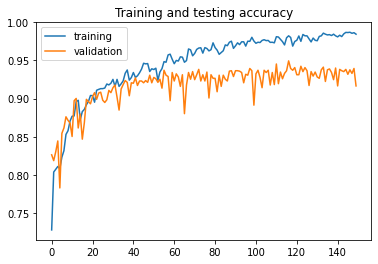

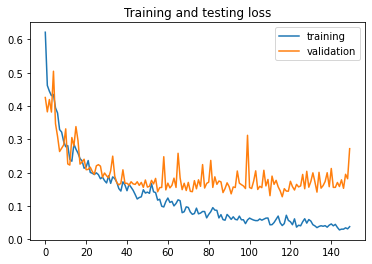

In [ ]:
import matplotlib.pyplot as plt


# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and testing accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and testing loss')



In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test,axis = 1) 
cm_1 = confusion_matrix(y_true,y_pred)
cm_1

array([[1016,  133],
       [  59, 1062]])

[Text(0, 0.5, 'bcc'), Text(0, 1.5, 'nobcc')]

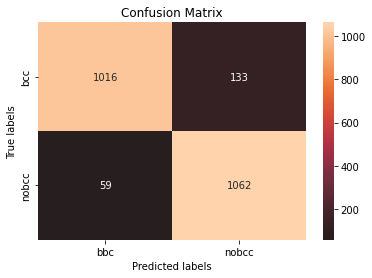

In [ ]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(cm_1, annot=True, ax = ax, fmt='2.0f', center=1); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['bbc', 'nobcc'])
ax.yaxis.set_ticklabels(['bcc', 'nobcc'])

In [ ]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.94511628 0.88870293]
recall: [0.88424717 0.94736842]
fscore: [0.91366906 0.91709845]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, digits = 8))

              precision    recall  f1-score   support

           0  0.94511628 0.88424717 0.91366906      1149
           1  0.88870293 0.94736842 0.91709845      1121

    accuracy                      0.91541850      2270
   macro avg  0.91690960 0.91580780 0.91538376      2270
weighted avg  0.91725753 0.91541850 0.91536260      2270



In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


precision = precision_score(y_true, y_pred)
print('precision_score: {}'.format(precision))

sensibilidad = recall_score(y_true, y_pred)
print('recall_score: {}'.format(sensibilidad))

puntaje = f1_score(y_true, y_pred)
print('f1_score: {}'.format(puntaje))

accuracy_score(y_true, y_pred)

precision_score: 0.8887029288702929
recall_score: 0.9473684210526315
f1_score: 0.9170984455958548


0.9154185022026432

In [ ]:
from keras.models import load_model
model.save('/content/drive/My Drive/modelos_h5/x_cnn_svm_keras_web.h5')

In [ ]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(64, 64))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
from keras.preprocessing import image
img_path = '/content/drive/My Drive/Colab Notebooks/image.png'   
new_image = load_image(img_path)

In [ ]:
y_predict_s = model.predict(new_image)


In [ ]:
print(y_predict_s)

[[-0.39929238 -1.6235093 ]]


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/modelos_h5/x_cnn_svm_keras_web.h5')

In [ ]:
pd.set_option('display.max_rows', 500)
df = pd.DataFrame({'Predicción': pd.Categorical(y_pred), 'Etiqueta': pd.Categorical(y_true)})
df.head(200)

,Predicción,Etiqueta
0,0,0
1,1,1
2,1,0
3,1,1
4,1,1
5,0,0
6,0,0
7,1,1
8,1,1
9,0,0
